**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

In [2]:
df=pd.read_csv(r'../data/datatraining.txt')
test1=pd.read_csv(r'../data/datatest.txt')
test2=pd.read_csv(r'../data/datatest2.txt')
df=df.append(test1)
df=df.append(test2)

In [3]:
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['Time']= df['date'].apply(lambda x:x.time())
df['Date']= df['date'].apply(lambda x:x.date())
df['Time'] =  pd.to_timedelta(str(x) for x in df['Time'])
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop('date', axis=1, inplace=True)

df['time']=df['Time'].apply(lambda x:int(str(x)[7:9]+str(x)[10:12]))
#df['time'] = df['time'].astype(int)
df['Holiday'] = df['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )


print(df['Occupancy'].value_counts(normalize=True))
df['Occupancy'].value_counts()

0    0.768969
1    0.231031
Name: Occupancy, dtype: float64


0    15810
1     4750
Name: Occupancy, dtype: int64

In [4]:
df.drop(['Date','time'],axis=1,inplace=True)

In [19]:
rows2remove = np.random.choice(df[df['Occupancy'] == 1].index, 4750- 1000, replace=False)
df = df.drop(index=rows2remove, axis=0)
print(len(df))
print('Dataset shape %s' % Counter(df2['Occupancy']))

13700
Dataset shape Counter({0: 13153, 1: 574})


In [20]:
print(df['Occupancy'].value_counts(normalize=True))
df['Occupancy'].value_counts()

0    0.959124
1    0.040876
Name: Occupancy, dtype: float64


0    13140
1      560
Name: Occupancy, dtype: int64

# Data Partitioning

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [22]:
from sklearn.model_selection import train_test_split
training, test = train_test_split(df[[col for col in df.columns]], test_size=0.3, random_state=100, stratify=df['Occupancy'])

In [23]:
attributes = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Holiday']

X_train =training[attributes].copy()
y_train=training['Occupancy'].values
X_test=test[attributes].copy()
y_test=test['Occupancy'].values

In [24]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1], dtype=int64), array([9198,  392], dtype=int64)),
 (array([0, 1], dtype=int64), array([3942,  168], dtype=int64)))

# Classification

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.994403892944039
F1-score [0.99708011 0.93294461]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3942
           1       0.91      0.95      0.93       168

    accuracy                           0.99      4110
   macro avg       0.96      0.97      0.97      4110
weighted avg       0.99      0.99      0.99      4110



# ROC curve

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [28]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

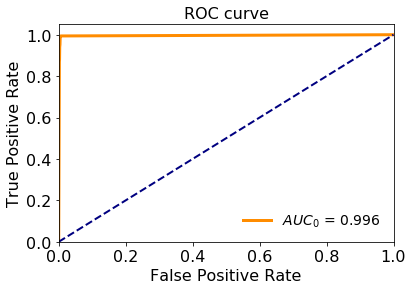

In [29]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Adjust the Decision Threshold

Accuracy 0.994403892944039
F1-score [0.99708011 0.93294461]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3942
           1       0.91      0.95      0.93       168

    accuracy                           0.99      4110
   macro avg       0.96      0.97      0.97      4110
weighted avg       0.99      0.99      0.99      4110



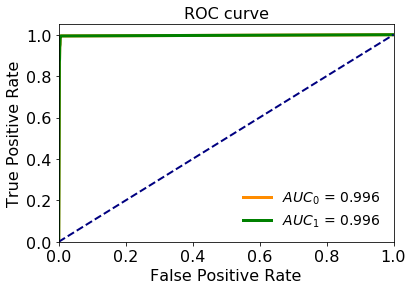

In [30]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

def adjusted_predict(X, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.55)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# PCA

In [31]:
from sklearn.decomposition import PCA

In [32]:
X_train.shape

(9590, 6)

In [33]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [34]:
X_pca.shape

(9590, 2)

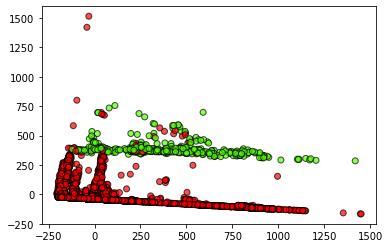

In [35]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# Undersampling

In [36]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

Using Theano backend.


### RandomUnderSampler

In [41]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 392, 1: 392})


In [42]:
print(len(X_res),len(X_test))

784 4110


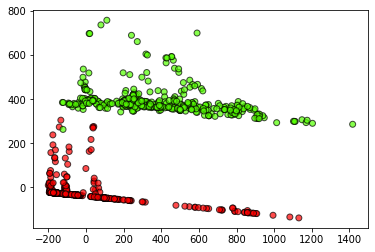

In [43]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9905109489051095
F1-score [0.99502868 0.896     ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3942
           1       0.81      1.00      0.90       168

    accuracy                           0.99      4110
   macro avg       0.91      1.00      0.95      4110
weighted avg       0.99      0.99      0.99      4110



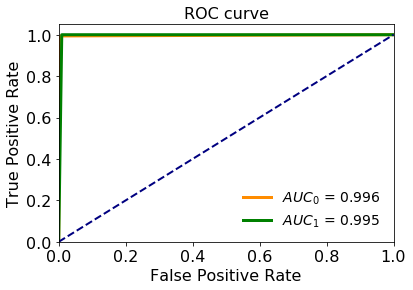

In [44]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### CondensedNearestNeighbour

In [45]:
import warnings
warnings.simplefilter("ignore")

In [46]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 392, 0: 53})


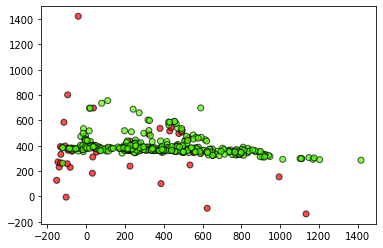

In [47]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.994403892944039
F1-score [0.99707714 0.93447293]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3942
           1       0.90      0.98      0.93       168

    accuracy                           0.99      4110
   macro avg       0.95      0.99      0.97      4110
weighted avg       0.99      0.99      0.99      4110



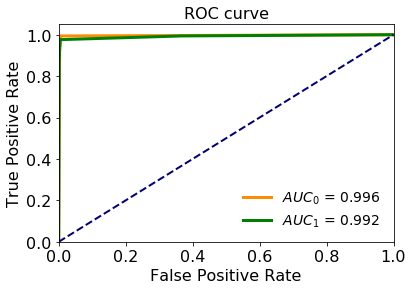

In [48]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Oversampling

In [49]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### RandomOverSampler

In [50]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 9198, 1: 9198})


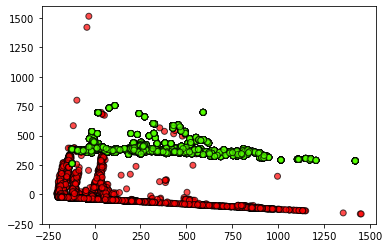

In [51]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9956204379562044
F1-score [0.997714   0.94797688]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3942
           1       0.92      0.98      0.95       168

    accuracy                           1.00      4110
   macro avg       0.96      0.99      0.97      4110
weighted avg       1.00      1.00      1.00      4110



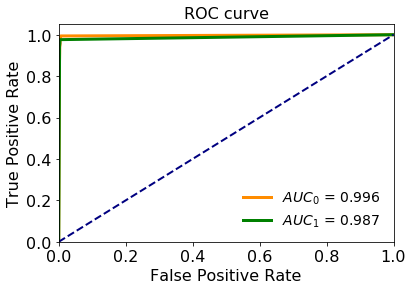

In [53]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### SMOTE

In [36]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 3306, 0: 3306})


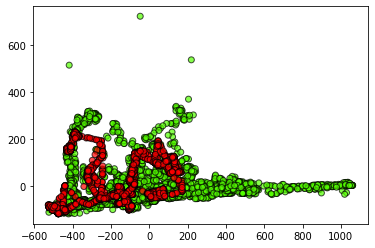

In [37]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9429735234215886
F1-score [0.46835443 0.96987088]
              precision    recall  f1-score   support

           0       0.36      0.67      0.47        55
           1       0.99      0.95      0.97      1418

    accuracy                           0.94      1473
   macro avg       0.67      0.81      0.72      1473
weighted avg       0.96      0.94      0.95      1473



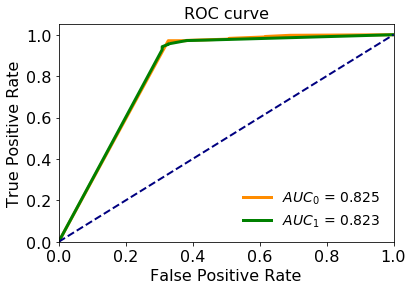

In [38]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Class Weight 

Accuracy 0.956551255940258
F1-score [0.56164384 0.97714286]
              precision    recall  f1-score   support

           0       0.45      0.75      0.56        55
           1       0.99      0.96      0.98      1418

    accuracy                           0.96      1473
   macro avg       0.72      0.86      0.77      1473
weighted avg       0.97      0.96      0.96      1473



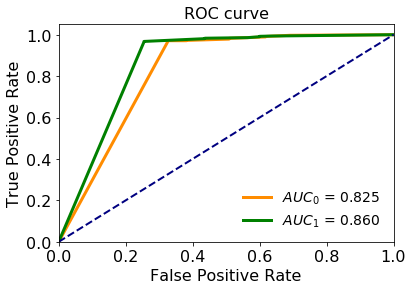

In [47]:
clf = DecisionTreeClassifier(min_samples_leaf=3, class_weight={0:5, 1: 1}, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Meta-Cost Sensitive Classifier

In [48]:

from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score

cost_mat : array-like of shape = [n_samples, 4]

Cost matrix of the classification problem Where the columns represents the costs of: false positives, false negatives, true positives and true negatives, for each example.

In [64]:
attributes = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Holiday']

X_train =training[attributes].copy()
y_train=training[['Occupancy']].values
X_test=test[attributes].copy()
y_test=test[['Occupancy']].values

In [71]:
cost = [1, 10, 1, 1]
cost_mat = np.array([cost] * len(X_train))
cost_mat.shape

(3434, 4)

In [66]:
cost_mat 

array([[ 1, 10,  1,  1],
       [ 1, 10,  1,  1],
       [ 1, 10,  1,  1],
       ...,
       [ 1, 10,  1,  1],
       [ 1, 10,  1,  1],
       [ 1, 10,  1,  1]])

In [77]:
cost = [[1, 10, 1, 1]]
cost = np.array(cost)

In [69]:
y_train.shape

(3434, 1)

In [78]:
clf = CostSensitiveDecisionTreeClassifier()
clf.fit(X_train, y_train, cost)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [50]:
cost_mat_test = np.array([cost] * len(X_test))
print(savings_score(y_test, y_pred, cost_mat_test))
print(savings_score(y_test, y_pred0, cost_mat_test))

0.17333333333333334
0.22666666666666668


# Scikit-plot

In [51]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [52]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.932
F1-score [0.96046512 0.75714286]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       855
           1       0.79      0.73      0.76       145

    accuracy                           0.93      1000
   macro avg       0.87      0.85      0.86      1000
weighted avg       0.93      0.93      0.93      1000



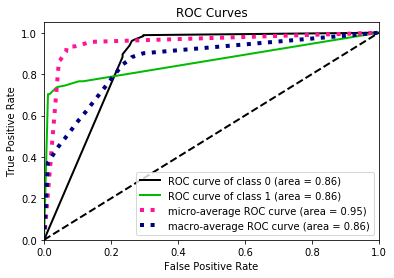

In [53]:
plot_roc(y_test, y_score)
plt.show()

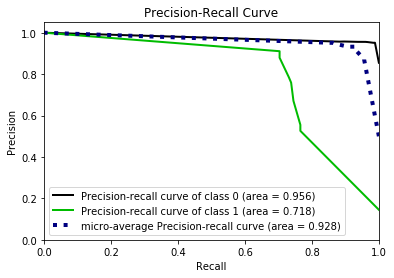

In [54]:
plot_precision_recall(y_test, y_score)
plt.show()

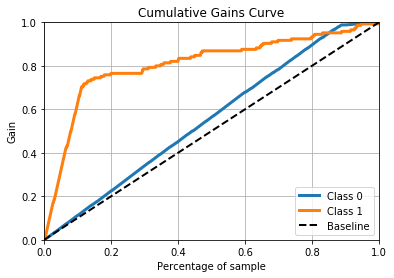

In [55]:
plot_cumulative_gain(y_test, y_score)
plt.show()

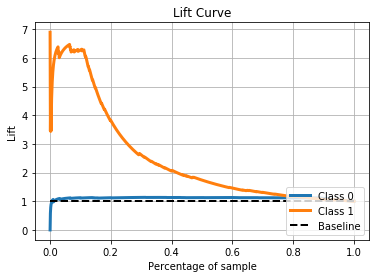

In [56]:
plot_lift_curve(y_test, y_score)
plt.show()